# Convolutional Neural Network (CNN) for Intel Image Classification Dataset
### Data

This code was inspired from this [kaggle code](https://www.kaggle.com/code/vyom71/image-classification-cnn-intel-data).

The dataset consists of approximately 25,000 images, each resized to 150x150 pixels, categorized into six classes:

| Class     | Label |
|-----------|-------|
| Buildings | 0     |
| Forest    | 1     |
| Glacier   | 2     |
| Mountain  | 3     |
| Sea       | 4     |
| Street    | 5     |

The dataset is structured into three parts:

- **Train**: ~14,000 images for training models.
- **Test**: ~3,000 images for testing.
- **Prediction**: ~7,000 images for model evaluation.


## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/nelsonloureiro/anaconda3/envs/py3-TF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/nelsonloureiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
train_dir = f"{path}/seg_train/seg_train"
test_dir = f"{path}/seg_test/seg_test"

In [4]:
classes = os.listdir(train_dir)
print("Classes: ",classes)

Classes:  ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [5]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")  
total = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
print(f"Total images are {total}")

forest: 2271 images
buildings: 2191 images
glacier: 2404 images
street: 2382 images
mountain: 2512 images
sea: 2274 images
Total images are 14034


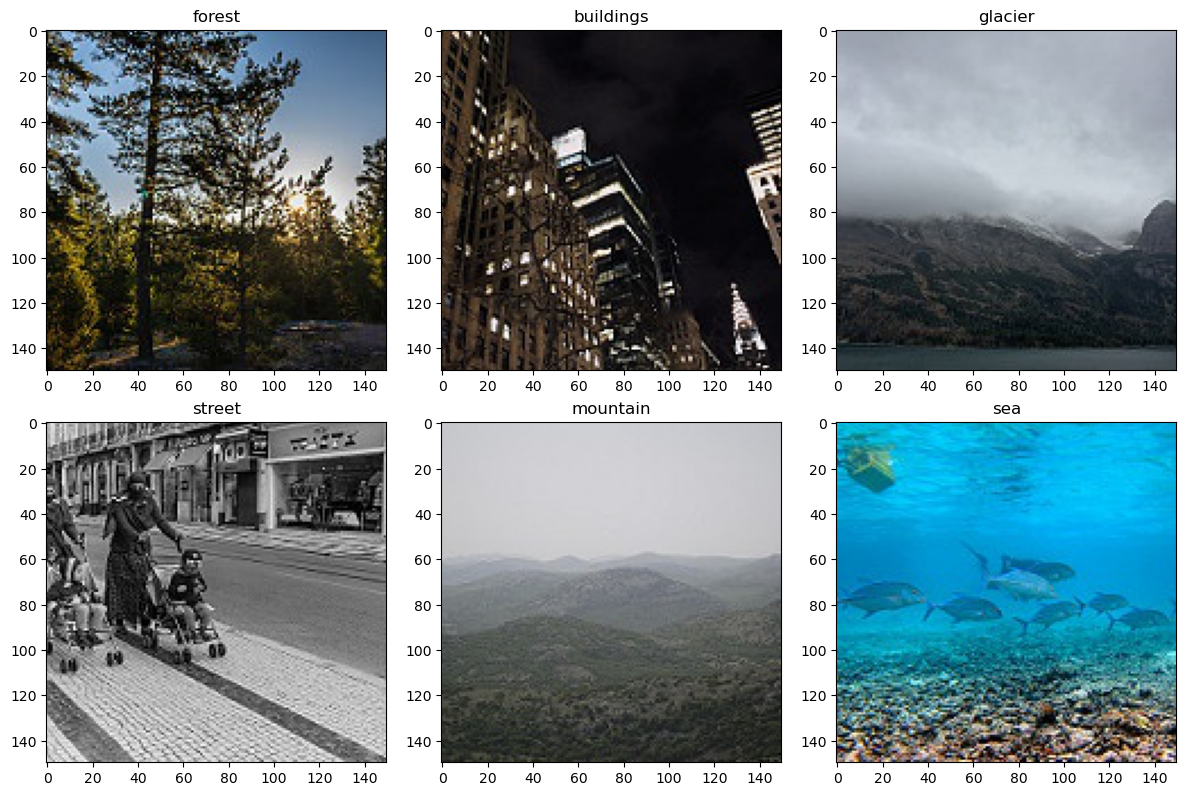

In [6]:
plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
    cls_path = os.path.join(train_dir,cls)
    img_path = os.path.join(cls_path,os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

#### I created 3 pipelines for Training, Validation and Testing data so Flow From Directory take cares about everything from data gethering from directory apply data augmentation (on-the-fly) divide into training and validation classes with given batch_size and target_size

In [8]:
img_size = (150,150)
batch_size = 32

print('Training subset:')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

print('\nValidation subset:')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

print('\nTest subset:')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Training subset:
Found 11230 images belonging to 6 classes.

Validation subset:
Found 2804 images belonging to 6 classes.

Test subset:
Found 3000 images belonging to 6 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    shuffle = False,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3000 images belonging to 6 classes.


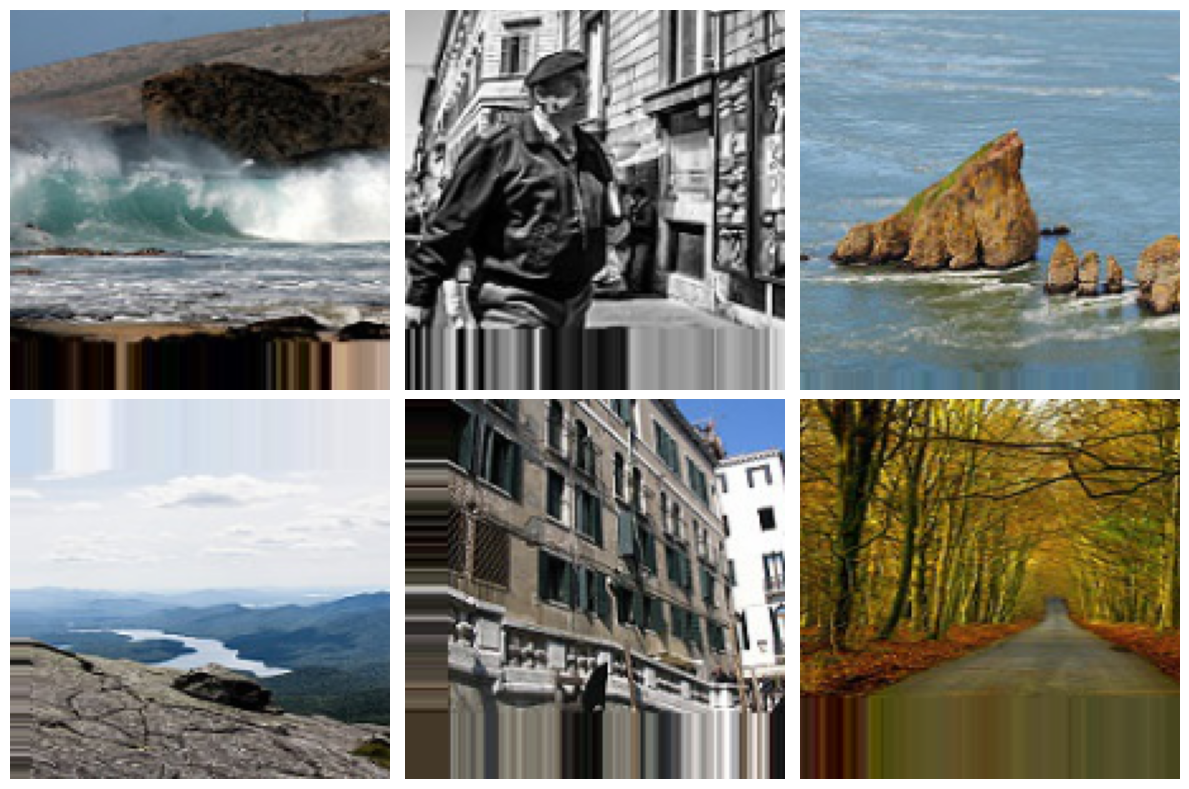

In [10]:
# Displaying a single batch of images
x_batch , y_batch = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
x_batch.shape, y_batch.shape

((32, 150, 150, 3), (32, 6))

## CNN Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import numpy as np

%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix,classification_report
import io
import itertools

## Defining hyperparameters

In [13]:
HP_KERNEL_SIZE = hp.HParam('kernel_size', hp.Discrete([3, 5, 7]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.2, 0.5]))
HP_OPTIMISER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'
METRIC_PRECISION = 'precision'
METRIC_RECALL = 'recall'
METRIC_F1 = 'f1_score'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_OPTIMISER, HP_KERNEL_SIZE, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
             hp.Metric(METRIC_PRECISION, display_name='Precision'),
             hp.Metric(METRIC_RECALL, display_name='Recall'),
             hp.Metric(METRIC_F1, display_name='F1 Score')]
  )

## Creating functions for training our model and for logging purposes

#### Confusion matrix

In [14]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [15]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [16]:
def log_confusion_matrix(model, file_writer_cm):
    predictions = model.predict(test_generator)
    labels = {value: key for key, value in test_generator.class_indices.items()}

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    # for i in range(10): 
    #     print(f"True Class: {true_classes[i]} | Predicted Class: {predicted_classes[i]}")

    cm = confusion_matrix(true_classes, predicted_classes)
    
    figure = plot_confusion_matrix(cm, class_names=labels.values())
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=1)  

    # c.f.: https://www.statology.org/sklearn-classification-report/
    return classification_report(true_classes, predicted_classes, target_names=labels.values(), output_dict=True, zero_division=1)
    

#### Model

In [17]:
def train_test_model(log_dir, hparams, file_writer_cm):
  model = tf.keras.models.Sequential([
    Input(shape=(150,150,3)),
    Conv2D(filters=32, kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Conv2D(filters=64,kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Conv2D(filters=128,kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(hparams[HP_DROPOUT]),
    Dense(6, activation='softmax')
  ])
  model.compile(optimizer=hparams[HP_OPTIMISER], loss='categorical_crossentropy', metrics=['accuracy'])
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  
  model.fit(
    train_generator,
    # in one epoch the generator will pass through all the training samples once. 
    steps_per_epoch = int( np.ceil(train_generator.samples / batch_size) ),
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback],
    validation_steps = int( np.ceil(validation_generator.samples / batch_size) ),
    verbose=2
  )

  #print("Average test loss: ", np.average(training_history.history['loss']))
  report = log_confusion_matrix(model, file_writer_cm)

  # Overall metrics
  accuracy = report['accuracy']
  weighted_precision = report['weighted avg']['precision']
  weighted_recall = report['weighted avg']['recall']
  weighted_f1 = report['weighted avg']['f1-score']

  return accuracy, weighted_precision, weighted_recall, weighted_f1

## Training the model with the different hyperparameters

In [18]:
# Creating a function to log the resuls
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
        accuracy, precision, recall, f1_score = train_test_model(log_dir, hparams, file_writer_cm)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        tf.summary.scalar(METRIC_PRECISION, precision, step=1)
        tf.summary.scalar(METRIC_RECALL, recall, step=1)
        tf.summary.scalar(METRIC_F1, f1_score, step=1)

In [19]:
# Performing a grid search on the hyperparameters we need to test
session_num = 0

for optimiser in HP_OPTIMISER.domain.values:
    for kernel_size in HP_KERNEL_SIZE.domain.values:
        for dropout in HP_DROPOUT.domain.values:
            hparams = {
                HP_KERNEL_SIZE: kernel_size,
                HP_DROPOUT: dropout,
                HP_OPTIMISER: optimiser
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)

            session_num += 1

--- Starting trial: run-0
{'kernel_size': 3, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/30


2025-01-03 19:19:31.208807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-03 19:19:31.213515: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-01-03 19:21:35.046645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 138s - loss: 1.0970 - accuracy: 0.5591 - val_loss: 0.9069 - val_accuracy: 0.6676 - 138s/epoch - 393ms/step
Epoch 2/30
351/351 - 120s - loss: 0.8328 - accuracy: 0.6843 - val_loss: 0.7325 - val_accuracy: 0.7372 - 120s/epoch - 343ms/step
Epoch 3/30
351/351 - 124s - loss: 0.7033 - accuracy: 0.7369 - val_loss: 0.6436 - val_accuracy: 0.7657 - 124s/epoch - 354ms/step
Epoch 4/30
351/351 - 122s - loss: 0.6444 - accuracy: 0.7606 - val_loss: 0.6207 - val_accuracy: 0.7710 - 122s/epoch - 347ms/step
Epoch 5/30
351/351 - 122s - loss: 0.5894 - accuracy: 0.7874 - val_loss: 0.5659 - val_accuracy: 0.7967 - 122s/epoch - 347ms/step
Epoch 6/30
351/351 - 122s - loss: 0.5527 - accuracy: 0.7981 - val_loss: 0.5371 - val_accuracy: 0.8163 - 122s/epoch - 347ms/step
Epoch 7/30
351/351 - 121s - loss: 0.5111 - accuracy: 0.8099 - val_loss: 0.5205 - val_accuracy: 0.8156 - 121s/epoch - 346ms/step
Epoch 8/30
351/351 - 133s - loss: 0.5126 - accuracy: 0.8129 - val_loss: 0.5110 - val_accuracy: 0.8199 - 133s/epoch 

2025-01-03 20:23:09.517518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 10s 108ms/step
--- Starting trial: run-1
{'kernel_size': 3, 'dropout': 0.5, 'optimizer': 'adam'}
Epoch 1/30


2025-01-03 20:23:20.295817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-03 20:25:14.718420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 127s - loss: 1.2210 - accuracy: 0.5069 - val_loss: 0.9519 - val_accuracy: 0.6334 - 127s/epoch - 363ms/step
Epoch 2/30
351/351 - 126s - loss: 0.9510 - accuracy: 0.6284 - val_loss: 0.8475 - val_accuracy: 0.6740 - 126s/epoch - 358ms/step
Epoch 3/30
351/351 - 126s - loss: 0.8324 - accuracy: 0.6828 - val_loss: 0.7365 - val_accuracy: 0.7361 - 126s/epoch - 359ms/step
Epoch 4/30
351/351 - 126s - loss: 0.7476 - accuracy: 0.7214 - val_loss: 0.6808 - val_accuracy: 0.7650 - 126s/epoch - 359ms/step
Epoch 5/30
351/351 - 125s - loss: 0.6849 - accuracy: 0.7509 - val_loss: 0.5979 - val_accuracy: 0.7864 - 125s/epoch - 356ms/step
Epoch 6/30
351/351 - 125s - loss: 0.6323 - accuracy: 0.7660 - val_loss: 0.5867 - val_accuracy: 0.7907 - 125s/epoch - 356ms/step
Epoch 7/30
351/351 - 124s - loss: 0.5927 - accuracy: 0.7853 - val_loss: 0.6351 - val_accuracy: 0.7657 - 124s/epoch - 354ms/step
Epoch 8/30
351/351 - 125s - loss: 0.5718 - accuracy: 0.7924 - val_loss: 0.5827 - val_accuracy: 0.8024 - 125s/epoch 

2025-01-03 21:26:14.924609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 10s 106ms/step
--- Starting trial: run-2
{'kernel_size': 5, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/30


2025-01-03 21:26:25.489887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-03 21:29:50.763887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 223s - loss: 1.1960 - accuracy: 0.5300 - val_loss: 0.9625 - val_accuracy: 0.6138 - 223s/epoch - 636ms/step
Epoch 2/30
351/351 - 222s - loss: 0.9444 - accuracy: 0.6326 - val_loss: 0.9290 - val_accuracy: 0.6245 - 222s/epoch - 632ms/step
Epoch 3/30
351/351 - 222s - loss: 0.8251 - accuracy: 0.6859 - val_loss: 0.7046 - val_accuracy: 0.7389 - 222s/epoch - 631ms/step
Epoch 4/30
351/351 - 223s - loss: 0.7197 - accuracy: 0.7393 - val_loss: 0.7225 - val_accuracy: 0.7304 - 223s/epoch - 636ms/step
Epoch 5/30
351/351 - 227s - loss: 0.6743 - accuracy: 0.7482 - val_loss: 0.7161 - val_accuracy: 0.7379 - 227s/epoch - 647ms/step
Epoch 6/30
351/351 - 231s - loss: 0.6184 - accuracy: 0.7733 - val_loss: 0.5805 - val_accuracy: 0.7775 - 231s/epoch - 659ms/step
Epoch 7/30
351/351 - 225s - loss: 0.6331 - accuracy: 0.7706 - val_loss: 0.5689 - val_accuracy: 0.7964 - 225s/epoch - 642ms/step
Epoch 8/30
351/351 - 228s - loss: 0.5716 - accuracy: 0.7940 - val_loss: 0.5637 - val_accuracy: 0.7860 - 228s/epoch 

2025-01-03 23:20:31.663778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 18s 193ms/step
--- Starting trial: run-3
{'kernel_size': 5, 'dropout': 0.5, 'optimizer': 'adam'}
Epoch 1/30


2025-01-03 23:20:50.318028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-03 23:24:18.320300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 226s - loss: 1.2147 - accuracy: 0.5046 - val_loss: 1.0399 - val_accuracy: 0.5902 - 226s/epoch - 644ms/step
Epoch 2/30
351/351 - 225s - loss: 0.9733 - accuracy: 0.6207 - val_loss: 0.9070 - val_accuracy: 0.6562 - 225s/epoch - 642ms/step
Epoch 3/30
351/351 - 223s - loss: 0.8509 - accuracy: 0.6701 - val_loss: 0.8482 - val_accuracy: 0.6780 - 223s/epoch - 637ms/step
Epoch 4/30
351/351 - 223s - loss: 0.7874 - accuracy: 0.7089 - val_loss: 0.7030 - val_accuracy: 0.7340 - 223s/epoch - 636ms/step
Epoch 5/30
351/351 - 223s - loss: 0.7337 - accuracy: 0.7268 - val_loss: 0.6854 - val_accuracy: 0.7436 - 223s/epoch - 635ms/step
Epoch 6/30
351/351 - 224s - loss: 0.6954 - accuracy: 0.7446 - val_loss: 0.6377 - val_accuracy: 0.7718 - 224s/epoch - 638ms/step
Epoch 7/30
351/351 - 224s - loss: 0.6782 - accuracy: 0.7521 - val_loss: 0.6426 - val_accuracy: 0.7671 - 224s/epoch - 639ms/step
Epoch 8/30
351/351 - 231s - loss: 0.6422 - accuracy: 0.7679 - val_loss: 0.6472 - val_accuracy: 0.7753 - 231s/epoch 

2025-01-04 01:12:53.021869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 18s 193ms/step
--- Starting trial: run-4
{'kernel_size': 7, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/30


2025-01-04 01:13:11.690893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 01:18:45.501303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 362s - loss: 1.1807 - accuracy: 0.5133 - val_loss: 1.0496 - val_accuracy: 0.5738 - 362s/epoch - 1s/step
Epoch 2/30
351/351 - 358s - loss: 0.9676 - accuracy: 0.6185 - val_loss: 0.9111 - val_accuracy: 0.6427 - 358s/epoch - 1s/step
Epoch 3/30
351/351 - 357s - loss: 0.8373 - accuracy: 0.6789 - val_loss: 0.7913 - val_accuracy: 0.7126 - 357s/epoch - 1s/step
Epoch 4/30
351/351 - 355s - loss: 0.7559 - accuracy: 0.7197 - val_loss: 0.6712 - val_accuracy: 0.7578 - 355s/epoch - 1s/step
Epoch 5/30
351/351 - 358s - loss: 0.7134 - accuracy: 0.7400 - val_loss: 0.6648 - val_accuracy: 0.7643 - 358s/epoch - 1s/step
Epoch 6/30
351/351 - 360s - loss: 0.6732 - accuracy: 0.7516 - val_loss: 0.7511 - val_accuracy: 0.7318 - 360s/epoch - 1s/step
Epoch 7/30
351/351 - 360s - loss: 0.6472 - accuracy: 0.7638 - val_loss: 0.6214 - val_accuracy: 0.7703 - 360s/epoch - 1s/step
Epoch 8/30
351/351 - 358s - loss: 0.6240 - accuracy: 0.7741 - val_loss: 0.6516 - val_accuracy: 0.7746 - 358s/epoch - 1s/step
Epoch 9/30


2025-01-04 04:11:48.788492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 29s 304ms/step
--- Starting trial: run-5
{'kernel_size': 7, 'dropout': 0.5, 'optimizer': 'adam'}
Epoch 1/30


2025-01-04 04:12:17.903426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 04:17:49.754938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 360s - loss: 1.3372 - accuracy: 0.4529 - val_loss: 1.0516 - val_accuracy: 0.5888 - 360s/epoch - 1s/step
Epoch 2/30
351/351 - 355s - loss: 1.1017 - accuracy: 0.5567 - val_loss: 0.9576 - val_accuracy: 0.6159 - 355s/epoch - 1s/step
Epoch 3/30
351/351 - 355s - loss: 0.9862 - accuracy: 0.6010 - val_loss: 0.9974 - val_accuracy: 0.5906 - 355s/epoch - 1s/step
Epoch 4/30
351/351 - 353s - loss: 0.9296 - accuracy: 0.6330 - val_loss: 0.9011 - val_accuracy: 0.6394 - 353s/epoch - 1s/step
Epoch 5/30
351/351 - 358s - loss: 0.8766 - accuracy: 0.6579 - val_loss: 0.8095 - val_accuracy: 0.6912 - 358s/epoch - 1s/step
Epoch 6/30
351/351 - 360s - loss: 0.8186 - accuracy: 0.6933 - val_loss: 0.7407 - val_accuracy: 0.7311 - 360s/epoch - 1s/step
Epoch 7/30
351/351 - 362s - loss: 0.7833 - accuracy: 0.7090 - val_loss: 0.7074 - val_accuracy: 0.7418 - 362s/epoch - 1s/step
Epoch 8/30
351/351 - 354s - loss: 0.7480 - accuracy: 0.7243 - val_loss: 0.6800 - val_accuracy: 0.7632 - 354s/epoch - 1s/step
Epoch 9/30


2025-01-04 07:10:03.145778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 28s 297ms/step
--- Starting trial: run-6
{'kernel_size': 3, 'dropout': 0.2, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 07:10:31.623915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 07:12:22.840990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 124s - loss: 1.4788 - accuracy: 0.4004 - val_loss: 1.2817 - val_accuracy: 0.4782 - 124s/epoch - 353ms/step
Epoch 2/30
351/351 - 125s - loss: 1.1607 - accuracy: 0.5439 - val_loss: 1.0767 - val_accuracy: 0.5788 - 125s/epoch - 356ms/step
Epoch 3/30
351/351 - 129s - loss: 1.0549 - accuracy: 0.5860 - val_loss: 1.0134 - val_accuracy: 0.6027 - 129s/epoch - 368ms/step
Epoch 4/30
351/351 - 128s - loss: 0.9846 - accuracy: 0.6211 - val_loss: 0.9327 - val_accuracy: 0.6512 - 128s/epoch - 365ms/step
Epoch 5/30
351/351 - 122s - loss: 0.9353 - accuracy: 0.6451 - val_loss: 0.8799 - val_accuracy: 0.6665 - 122s/epoch - 348ms/step
Epoch 6/30
351/351 - 123s - loss: 0.9029 - accuracy: 0.6492 - val_loss: 0.8680 - val_accuracy: 0.6865 - 123s/epoch - 350ms/step
Epoch 7/30
351/351 - 124s - loss: 0.8613 - accuracy: 0.6691 - val_loss: 0.8429 - val_accuracy: 0.6822 - 124s/epoch - 353ms/step
Epoch 8/30
351/351 - 123s - loss: 0.8334 - accuracy: 0.6844 - val_loss: 0.8040 - val_accuracy: 0.6958 - 123s/epoch 

2025-01-04 08:12:19.999618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 9s 98ms/step
--- Starting trial: run-7
{'kernel_size': 3, 'dropout': 0.5, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 08:12:29.773587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 08:14:21.873154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 124s - loss: 1.4822 - accuracy: 0.4028 - val_loss: 1.2609 - val_accuracy: 0.5178 - 124s/epoch - 354ms/step
Epoch 2/30
351/351 - 124s - loss: 1.1926 - accuracy: 0.5350 - val_loss: 1.1105 - val_accuracy: 0.5663 - 124s/epoch - 352ms/step
Epoch 3/30
351/351 - 128s - loss: 1.0935 - accuracy: 0.5745 - val_loss: 1.0380 - val_accuracy: 0.5995 - 128s/epoch - 366ms/step
Epoch 4/30
351/351 - 124s - loss: 1.0430 - accuracy: 0.5897 - val_loss: 1.0137 - val_accuracy: 0.6205 - 124s/epoch - 352ms/step
Epoch 5/30
351/351 - 123s - loss: 1.0001 - accuracy: 0.6153 - val_loss: 1.0416 - val_accuracy: 0.5977 - 123s/epoch - 350ms/step
Epoch 6/30
351/351 - 123s - loss: 0.9502 - accuracy: 0.6311 - val_loss: 0.8999 - val_accuracy: 0.6619 - 123s/epoch - 352ms/step
Epoch 7/30
351/351 - 126s - loss: 0.9322 - accuracy: 0.6483 - val_loss: 0.8911 - val_accuracy: 0.6459 - 126s/epoch - 360ms/step
Epoch 8/30
351/351 - 123s - loss: 0.9003 - accuracy: 0.6565 - val_loss: 0.8908 - val_accuracy: 0.6598 - 123s/epoch 

2025-01-04 09:14:36.354641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 10s 106ms/step
--- Starting trial: run-8
{'kernel_size': 5, 'dropout': 0.2, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 09:14:47.251819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 09:18:21.434223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 232s - loss: 1.4533 - accuracy: 0.4296 - val_loss: 1.3151 - val_accuracy: 0.4743 - 232s/epoch - 661ms/step
Epoch 2/30
351/351 - 224s - loss: 1.1573 - accuracy: 0.5386 - val_loss: 1.1350 - val_accuracy: 0.5496 - 224s/epoch - 638ms/step
Epoch 3/30
351/351 - 226s - loss: 1.0737 - accuracy: 0.5791 - val_loss: 1.0824 - val_accuracy: 0.5717 - 226s/epoch - 643ms/step
Epoch 4/30
351/351 - 222s - loss: 1.0262 - accuracy: 0.5978 - val_loss: 0.9561 - val_accuracy: 0.6345 - 222s/epoch - 632ms/step
Epoch 5/30
351/351 - 221s - loss: 0.9673 - accuracy: 0.6209 - val_loss: 0.9256 - val_accuracy: 0.6509 - 221s/epoch - 630ms/step
Epoch 6/30
351/351 - 222s - loss: 0.9269 - accuracy: 0.6423 - val_loss: 0.8775 - val_accuracy: 0.6616 - 222s/epoch - 632ms/step
Epoch 7/30
351/351 - 222s - loss: 0.8728 - accuracy: 0.6642 - val_loss: 0.8414 - val_accuracy: 0.6705 - 222s/epoch - 631ms/step
Epoch 8/30
351/351 - 222s - loss: 0.8507 - accuracy: 0.6732 - val_loss: 0.8310 - val_accuracy: 0.6847 - 222s/epoch 

2025-01-04 11:07:14.732361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 20s 208ms/step
--- Starting trial: run-9
{'kernel_size': 5, 'dropout': 0.5, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 11:07:34.824762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 11:11:04.107936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 228s - loss: 1.4413 - accuracy: 0.4257 - val_loss: 1.1999 - val_accuracy: 0.5267 - 228s/epoch - 649ms/step
Epoch 2/30
351/351 - 227s - loss: 1.1846 - accuracy: 0.5254 - val_loss: 1.2002 - val_accuracy: 0.5207 - 227s/epoch - 648ms/step
Epoch 3/30
351/351 - 229s - loss: 1.0943 - accuracy: 0.5692 - val_loss: 1.0440 - val_accuracy: 0.5899 - 229s/epoch - 652ms/step
Epoch 4/30
351/351 - 226s - loss: 1.0379 - accuracy: 0.5939 - val_loss: 0.9713 - val_accuracy: 0.6213 - 226s/epoch - 643ms/step
Epoch 5/30
351/351 - 231s - loss: 0.9940 - accuracy: 0.6132 - val_loss: 0.9150 - val_accuracy: 0.6480 - 231s/epoch - 658ms/step
Epoch 6/30
351/351 - 228s - loss: 0.9526 - accuracy: 0.6268 - val_loss: 0.8810 - val_accuracy: 0.6655 - 228s/epoch - 650ms/step
Epoch 7/30
351/351 - 228s - loss: 0.9228 - accuracy: 0.6425 - val_loss: 0.9088 - val_accuracy: 0.6366 - 228s/epoch - 650ms/step
Epoch 8/30
351/351 - 229s - loss: 0.8895 - accuracy: 0.6551 - val_loss: 0.8135 - val_accuracy: 0.6951 - 229s/epoch 

2025-01-04 13:01:00.361525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 18s 188ms/step
--- Starting trial: run-10
{'kernel_size': 7, 'dropout': 0.2, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 13:01:18.575668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 13:06:49.935085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 360s - loss: 1.5096 - accuracy: 0.4014 - val_loss: 1.3147 - val_accuracy: 0.4961 - 360s/epoch - 1s/step
Epoch 2/30
351/351 - 360s - loss: 1.2453 - accuracy: 0.5093 - val_loss: 1.1314 - val_accuracy: 0.5357 - 360s/epoch - 1s/step
Epoch 3/30
351/351 - 363s - loss: 1.0984 - accuracy: 0.5610 - val_loss: 1.0858 - val_accuracy: 0.5749 - 363s/epoch - 1s/step
Epoch 4/30
351/351 - 360s - loss: 1.0323 - accuracy: 0.5894 - val_loss: 1.0210 - val_accuracy: 0.6070 - 360s/epoch - 1s/step
Epoch 5/30
351/351 - 359s - loss: 0.9920 - accuracy: 0.6143 - val_loss: 0.9290 - val_accuracy: 0.6419 - 359s/epoch - 1s/step
Epoch 6/30
351/351 - 356s - loss: 0.9385 - accuracy: 0.6335 - val_loss: 0.9057 - val_accuracy: 0.6384 - 356s/epoch - 1s/step
Epoch 7/30
351/351 - 358s - loss: 0.9026 - accuracy: 0.6507 - val_loss: 0.8645 - val_accuracy: 0.6751 - 358s/epoch - 1s/step
Epoch 8/30
351/351 - 363s - loss: 0.8791 - accuracy: 0.6598 - val_loss: 0.8286 - val_accuracy: 0.6872 - 363s/epoch - 1s/step
Epoch 9/30


2025-01-04 16:01:17.661964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 29s 306ms/step
--- Starting trial: run-11
{'kernel_size': 7, 'dropout': 0.5, 'optimizer': 'sgd'}
Epoch 1/30


2025-01-04 16:01:48.087684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 16:07:19.568511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 360s - loss: 1.5522 - accuracy: 0.3787 - val_loss: 1.2908 - val_accuracy: 0.4918 - 360s/epoch - 1s/step
Epoch 2/30
351/351 - 357s - loss: 1.2207 - accuracy: 0.5178 - val_loss: 1.1014 - val_accuracy: 0.5617 - 357s/epoch - 1s/step
Epoch 3/30
351/351 - 365s - loss: 1.1143 - accuracy: 0.5562 - val_loss: 1.0382 - val_accuracy: 0.5788 - 365s/epoch - 1s/step
Epoch 4/30
351/351 - 356s - loss: 1.0725 - accuracy: 0.5800 - val_loss: 0.9943 - val_accuracy: 0.6163 - 356s/epoch - 1s/step
Epoch 5/30
351/351 - 359s - loss: 1.0126 - accuracy: 0.6054 - val_loss: 0.9788 - val_accuracy: 0.6287 - 359s/epoch - 1s/step
Epoch 6/30
351/351 - 355s - loss: 0.9700 - accuracy: 0.6219 - val_loss: 0.9445 - val_accuracy: 0.6309 - 355s/epoch - 1s/step
Epoch 7/30
351/351 - 356s - loss: 0.9405 - accuracy: 0.6341 - val_loss: 0.8758 - val_accuracy: 0.6737 - 356s/epoch - 1s/step
Epoch 8/30
351/351 - 359s - loss: 0.9118 - accuracy: 0.6484 - val_loss: 0.8819 - val_accuracy: 0.6776 - 359s/epoch - 1s/step
Epoch 9/30


2025-01-04 19:01:23.322783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 36s 380ms/step


## Visualizing the hyperparameter results with Tensorboard

In [20]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.